In [1]:
% load_ext autoreload
% autoreload 2

% matplotlib inline

from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
data_path = 'data/bulldozers/'

In [4]:
bd_raw_train = pd.read_csv(f'{data_path}Train.csv'
                          , low_memory = False
                          , parse_dates = ['saledate']
                          , index_col = 'SalesID')

In [5]:
print(f'The shape of the train set is {bd_raw_train.shape}')


The shape of the train set is (401125, 52)


In [6]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

display_all(bd_raw_train.tail().transpose())

SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00
fiModelDesc,35NX2,35NX2,35NX2,30NX,30NX


In [7]:
allMissing = bd_raw_train.isnull().sum().sort_values(ascending=False)
percentage = (bd_raw_train.isnull().sum()/bd_raw_train.isnull().count()).sort_values(ascending=False)
missingData = pd.concat([allMissing, percentage*100], axis=1, keys=['TotalMissing', 'Percentage'])
missingData.head(40)

,TotalMissing,Percentage
Tip_Control,375906,93.712932
Blade_Extension,375906,93.712932
Blade_Width,375906,93.712932
Enclosure_Type,375906,93.712932
Engine_Horsepower,375906,93.712932
Pushblock,375906,93.712932
Scarifier,375895,93.710190
Hydraulics_Flow,357763,89.189903
Grouser_Tracks,357763,89.189903
Coupler_System,357667,89.165971


In [8]:
bd_raw_train = bd_raw_train.drop(
    labels = list(allMissing.index)[:21]
    , axis = 1)
display_all(bd_raw_train.tail().transpose())

SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00
fiModelDesc,35NX2,35NX2,35NX2,30NX,30NX
fiBaseModel,35,35,35,30,30


In [9]:
cols_drop = ['MachineID', 'ModelID']
bd_raw_train = bd_raw_train.drop(labels = cols_drop
                                , axis = 1)
bd_raw_train['datasource'] = bd_raw_train['datasource'].apply(str)
bd_raw_train['auctioneerID'] = bd_raw_train['auctioneerID'].apply(str)

In [10]:
bd_raw_train = bd_raw_train.drop(labels = ['MachineHoursCurrentMeter']
                                , axis = 1)

In [11]:
bd_raw_train['Tire_Size'] = bd_raw_train['Tire_Size'].fillna('None or Unspecified')
bd_raw_train['Grouser_Type'] = bd_raw_train['Grouser_Type'].fillna('na')
bd_raw_train['Track_Type'] = bd_raw_train['Track_Type'].fillna('na')
bd_raw_train['Stick_Length'] = bd_raw_train['Stick_Length'].fillna('None or Unspecified')
bd_raw_train['Pattern_Changer'] = bd_raw_train['Pattern_Changer'].fillna('None or Unspecified')
bd_raw_train['Thumb'] = bd_raw_train['Thumb'].fillna('None or Unspecified')
bd_raw_train['Undercarriage_Pad_Width'] = bd_raw_train['Undercarriage_Pad_Width'].fillna('None or Unspecified')
bd_raw_train['Ripper'] = bd_raw_train['Ripper'].fillna('None or Unspecified')
bd_raw_train['Drive_System'] = bd_raw_train['Drive_System'].fillna('na')
bd_raw_train['Ride_Control'] = bd_raw_train['Ride_Control'].fillna('None or Unspecified')
bd_raw_train['Transmission'] = bd_raw_train['Transmission'].fillna('None or Unspecified')
bd_raw_train['ProductSize'] = bd_raw_train['ProductSize'].fillna('na')
bd_raw_train['Forks'] = bd_raw_train['Forks'].fillna('None or Unspecified')
bd_raw_train['Coupler'] = bd_raw_train['Coupler'].fillna('None or Unspecified')
bd_raw_train['fiSecondaryDesc'] = bd_raw_train['fiSecondaryDesc'].fillna('na')
bd_raw_train['Hydraulics'] = bd_raw_train['Hydraulics'].fillna('None or Unspecified')
bd_raw_train['Enclosure'] = bd_raw_train['Enclosure'].fillna('None or Unspecified')

In [12]:
bd_raw_train.fiModelDesc = bd_raw_train.fiModelDesc.astype("category").cat.codes
bd_raw_train.fiBaseModel = bd_raw_train.fiBaseModel.astype("category").cat.codes

In [13]:
bd_raw_train['saleyear'] = bd_raw_train['saledate'].dt.year
bd_raw_train['salemonth'] = bd_raw_train['saledate'].dt.month
bd_raw_train['saleday'] = bd_raw_train['saledate'].dt.day
bd_raw_train['saleweekday'] = bd_raw_train['saledate'].dt.dayofweek
bd_raw_train['salequarter'] = bd_raw_train['saledate'].dt.quarter
bd_raw_train['saledoy'] = bd_raw_train['saledate'].dt.dayofyear
bd_raw_train = bd_raw_train.drop(labels = ['saledate'], axis = 1)

In [14]:
X = pd.get_dummies(bd_raw_train.drop(labels = ['SalePrice'], axis = 1)
                         , drop_first = True)
y = np.log(bd_raw_train['SalePrice'])

In [15]:
splits = TimeSeriesSplit(n_splits = 5)
rf_model = RandomForestRegressor(n_jobs = -1)
scores = cross_val_score(rf_model
                         , X
                         , y
                         , cv=splits
                         , scoring='neg_mean_squared_error')
print('The 95% confidence interval of the root mean squared log error is {:.2f} \u00B1 {:.2f}.'
      .format(np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

The 95% confidence interval of the root mean squared log error is 0.34 ± 0.07.


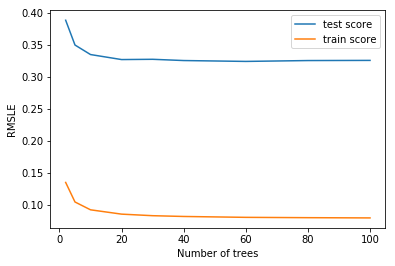

In [16]:
rf = RandomForestRegressor(n_jobs = -1)
estimators_grid = {"n_estimators" : [2, 5, 10, 20, 30, 40, 60, 80, 100] # number of trees in rf
              }
def my_loss_func(xx, yy):
    return np.sqrt(mean_squared_error(xx, yy))

my_scorer = make_scorer(my_loss_func, greater_is_better = False)
rf_estimators = GridSearchCV(estimator = rf
                             , cv = splits
                             , param_grid = estimators_grid
                             , verbose = 0
                             , scoring = my_scorer
                             , return_train_score = True)
rf_estimators.fit(X, y)

plt.plot(estimators_grid['n_estimators'], -rf_estimators.cv_results_['mean_test_score'], label='test score')
plt.plot(estimators_grid['n_estimators'], -rf_estimators.cv_results_['mean_train_score'], label='train score')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('RMSLE')
plt.show()

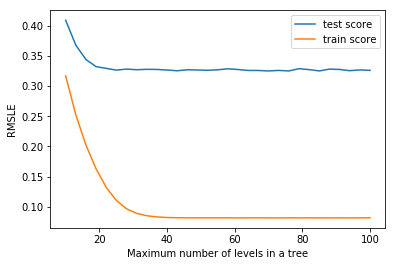

In [17]:
depths_grid = {"n_estimators" : [40] # number of trees in rf
               , "max_depth" : [int(x) for x in np.linspace(start = 10, stop = 100
                                                            , num = 31, endpoint = True)] # max num of levels in a tree
              }
rf_depths = GridSearchCV(estimator = rf
                         , cv = splits
                         , param_grid = depths_grid
                         , verbose = 0
                         , scoring = my_scorer
                         , return_train_score = True)
rf_depths.fit(X, y)

plt.plot(depths_grid['max_depth'], -rf_depths.cv_results_['mean_test_score'], label='test score')
plt.plot(depths_grid['max_depth'], -rf_depths.cv_results_['mean_train_score'], label='train score')
plt.legend()
plt.xlabel('Maximum number of levels in a tree')
plt.ylabel('RMSLE')
plt.show()

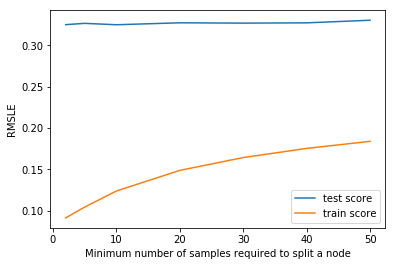

In [18]:
samples_split_grid = {"n_estimators" : [40] # number of trees in rf
               , "max_depth" : [30] # max num of levels in a tree
               , "min_samples_split" : [2, 5, 10, 20, 30, 40, 50] # min num of samples required to split a node
              }
rf_samples_split = GridSearchCV(estimator = rf
                                , cv = splits
                                , param_grid = samples_split_grid
                                , verbose = 0
                                , scoring = my_scorer
                                , return_train_score = True)
rf_samples_split.fit(X, y)

plt.plot(samples_split_grid['min_samples_split'], -rf_samples_split.cv_results_['mean_test_score'], label='test score')
plt.plot(samples_split_grid['min_samples_split'], -rf_samples_split.cv_results_['mean_train_score'], label='train score')
plt.legend()
plt.xlabel('Minimum number of samples required to split a node')
plt.ylabel('RMSLE')
plt.show()

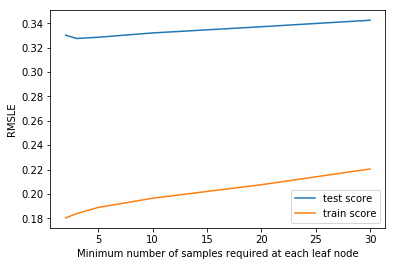

In [20]:
samples_leaf_grid = {"n_estimators" : [40] # number of trees in rf
               , "max_depth" : [30] # max num of levels in a tree
               , "min_samples_split" : [40] # min num of samples required to split a node
               , "min_samples_leaf" : [2, 3, 5, 10, 20, 30] # min num of samples req at each leaf node
              }
rf_samples_leaf = GridSearchCV(estimator = rf
                               , cv = splits
                               , param_grid = samples_leaf_grid
                               , verbose = 0
                               , scoring = my_scorer
                               , return_train_score = True)
rf_samples_leaf.fit(X, y)

plt.plot(samples_leaf_grid['min_samples_leaf'], -rf_samples_leaf.cv_results_['mean_test_score'], label='test score')
plt.plot(samples_leaf_grid['min_samples_leaf'], -rf_samples_leaf.cv_results_['mean_train_score'], label='train score')
plt.legend()
plt.xlabel('Minimum number of samples required at each leaf node')
plt.ylabel('RMSLE')
plt.show()

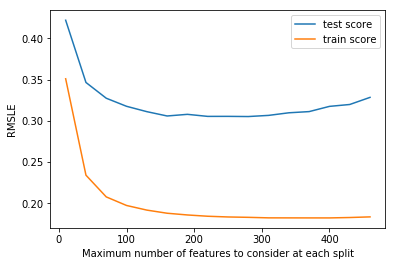

In [21]:
features_grid = {"n_estimators" : [40] # number of trees in rf
                 , "max_depth" : [30] # max num of levels in a tree
                 , "min_samples_split" : [40] # min num of samples required to split a node
                 , "min_samples_leaf" : [3] # min num of samples req at each leaf node
                 , "max_features" : list(range(10, X.shape[1], 30)) # number of features to consider at every split
                }
rf_features = GridSearchCV(estimator = rf
                           , cv = splits
                           , param_grid = features_grid
                           , verbose = 0
                           , scoring = my_scorer
                           , return_train_score = True)
rf_features.fit(X, y)

plt.plot(features_grid['max_features'], -rf_features.cv_results_['mean_test_score'], label='test score')
plt.plot(features_grid['max_features'], -rf_features.cv_results_['mean_train_score'], label='train score')
plt.legend()
plt.xlabel('Maximum number of features to consider at each split')
plt.ylabel('RMSLE')
plt.show()

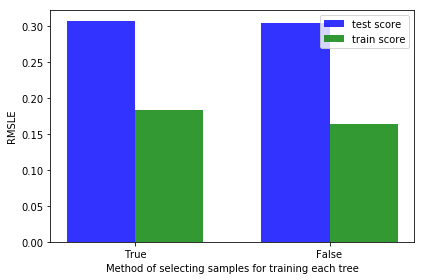

In [24]:
bootstrap_grid = {"n_estimators" : [40] # number of trees in rf
                  , "max_depth" : [30] # max num of levels in a tree
                  , "min_samples_split" : [40] # min num of samples required to split a node
                  , "min_samples_leaf" : [3] # min num of samples req at each leaf node
                  , "max_features" : [280] # number of features to consider at every split
                  , "bootstrap" : [True, False] # method of selecting samples for training each tree
                 }
rf_bootstrap = GridSearchCV(estimator = rf
                            , cv = splits
                            , param_grid = bootstrap_grid
                            , verbose = 0
                            , scoring = my_scorer
                            , return_train_score = True)
rf_bootstrap.fit(X, y)

fig, ax = plt.subplots()
rects1 = plt.bar(np.array([0, 1]), -rf_bootstrap.cv_results_['mean_test_score'], width = 0.35,
                 alpha = 0.8,
                 color = 'b',
                 label = 'test score')
 
rects2 = plt.bar(np.array([0, 1]) + 0.35, -rf_bootstrap.cv_results_['mean_train_score'], width = 0.35,
                 alpha = 0.8,
                 color = 'g',
                 label = 'train score')
 
plt.xlabel('Method of selecting samples for training each tree')
plt.ylabel('RMSLE')
plt.xticks(np.array([0, 1]) + 0.35/2, ('True', 'False'))
plt.legend()
 
plt.tight_layout()
plt.show()

In [25]:
rf_final = RandomForestRegressor(criterion = 'mse'
                                 , n_estimators = 40
                                 , max_depth = 30
                                 , min_samples_split = 40
                                 , min_samples_leaf = 3
                                 , max_features = 280
                                 , bootstrap = False
                                 , n_jobs = -1)
rf_final.fit(X, y)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=30,
           max_features=280, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=40,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)